In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [49]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


In [60]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

In [61]:
data.head()

,last_fico_range_high,int_rate,mo_sin_old_rev_tl_op,dti,annual_inc,zip_code,installment,fico_range_low,revol_util,total_acc,total_bc_limit,revol_bal,total_rev_hi_lim,bc_open_to_buy,credit_history_years,loan_status
0,699.0,0.1099,172.0,23.91,67000.0,0.286,196.41,695.0,0.337,30.0,12900.0,10660.0,31600.0,8436.0,15,0
1,644.0,0.1786,181.0,17.94,35000.0,0.440,253.18,670.0,0.224,22.0,44900.0,12256.0,54800.0,36084.0,16,0
2,634.0,0.1033,156.0,3.11,39000.0,0.850,162.12,680.0,0.079,14.0,29400.0,3173.0,40000.0,26227.0,15,0
3,684.0,0.1359,481.0,14.42,60000.0,0.084,322.79,715.0,0.492,33.0,16700.0,18847.0,38300.0,3179.0,41,0
4,699.0,0.0818,48.0,16.20,48000.0,0.347,282.78,660.0,0.217,19.0,8500.0,2713.0,12500.0,5787.0,11,0


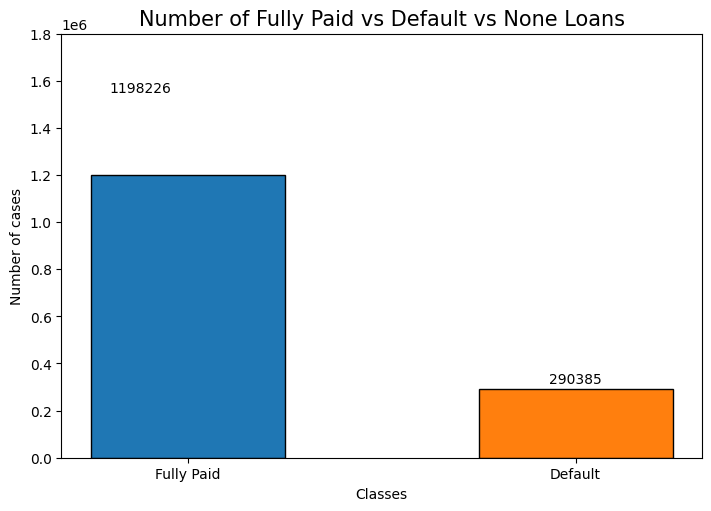

In [62]:
# Visualizing the encoded target

defalut_fully_paid = data['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Number of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.6,1550000,defalut_fully_paid[0])
#ax.text(3.7,400000,defalut_fully_paid[1])
# ax.text(5.6,1150000,none_)

fig.show()

In [63]:
# We see that the ration of Fully Paid and Default is almost 1 to 4.  (거의 1:4비율이다)
print(f"Ratio of: (Fully Paid) / Default  : {defalut_fully_paid[0]/defalut_fully_paid[1]}")

Ratio of: (Fully Paid) / Default  : 4.126335726707647


## Base Modeling

In [64]:
##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/test_dataset.csv"
test_data = pd.read_csv(test_data_path)

In [65]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

X_test = test_data.drop(columns='loan_status')
y_test = test_data[['loan_status']]

In [66]:
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.25, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 1116458 samples (75.0%)
Validation size: 372153 samples (25.0%)
Test size: 372153 samples (25.0%)


In [ ]:
"""scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Scaled data_x sample:\n", X_train_scaled.head())

# Z-score 저장 (나중에 다시 사용할 경우)
scaler_fitted = scaler"""

Scaled data_x sample:
          last_fico_range_high  int_rate  mo_sin_old_rev_tl_op       dti  \
76150               -0.362221 -1.624617             -0.113336  0.794963   
1146011              0.304149  0.167908              0.195037  0.139029   
633280              -0.119905  1.931454              0.758616 -0.762686   
688080              -2.179595 -0.090828             -1.719006  0.650750   
630322              -1.573804  1.517476             -0.645015  0.952356   

         annual_inc  zip_code  installment  fico_range_low  revol_util  \
76150     -0.009106 -0.895809     0.042345        0.530343   -0.717505   
1146011   -0.347189  0.920123     0.215595       -0.387273   -0.043482   
633280     0.335587  1.430253    -0.395291       -0.846080   -1.815315   
688080    -0.097247  1.305127    -0.140977       -0.999016   -0.701361   
630322    -0.317599 -1.418771    -0.092750       -1.151952    0.545784   

         total_acc  total_bc_limit  revol_bal  total_rev_hi_lim  \
76150     3.10

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=200,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42
)

[0]	validation_0-logloss:0.49200	validation_1-logloss:0.49201
[1]	validation_0-logloss:0.48744	validation_1-logloss:0.48748
[2]	validation_0-logloss:0.48300	validation_1-logloss:0.48305
[3]	validation_0-logloss:0.47868	validation_1-logloss:0.47875
[4]	validation_0-logloss:0.47448	validation_1-logloss:0.47456
[5]	validation_0-logloss:0.47038	validation_1-logloss:0.47048
[6]	validation_0-logloss:0.46638	validation_1-logloss:0.46649
[7]	validation_0-logloss:0.46248	validation_1-logloss:0.46261
[8]	validation_0-logloss:0.45867	validation_1-logloss:0.45881
[9]	validation_0-logloss:0.45496	validation_1-logloss:0.45511
[10]	validation_0-logloss:0.45133	validation_1-logloss:0.45149
[11]	validation_0-logloss:0.44778	validation_1-logloss:0.44795
[12]	validation_0-logloss:0.44432	validation_1-logloss:0.44450
[13]	validation_0-logloss:0.44093	validation_1-logloss:0.44112
[14]	validation_0-logloss:0.43761	validation_1-logloss:0.43782
[15]	validation_0-logloss:0.43437	validation_1-logloss:0.43459
[1

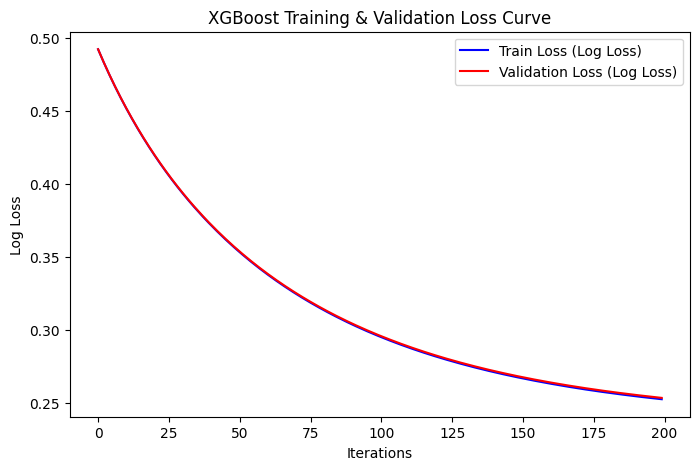

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94    299557
           1       0.74      0.71      0.73     72596

    accuracy                           0.90    372153
   macro avg       0.84      0.83      0.83    372153
weighted avg       0.89      0.90      0.90    372153



In [68]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

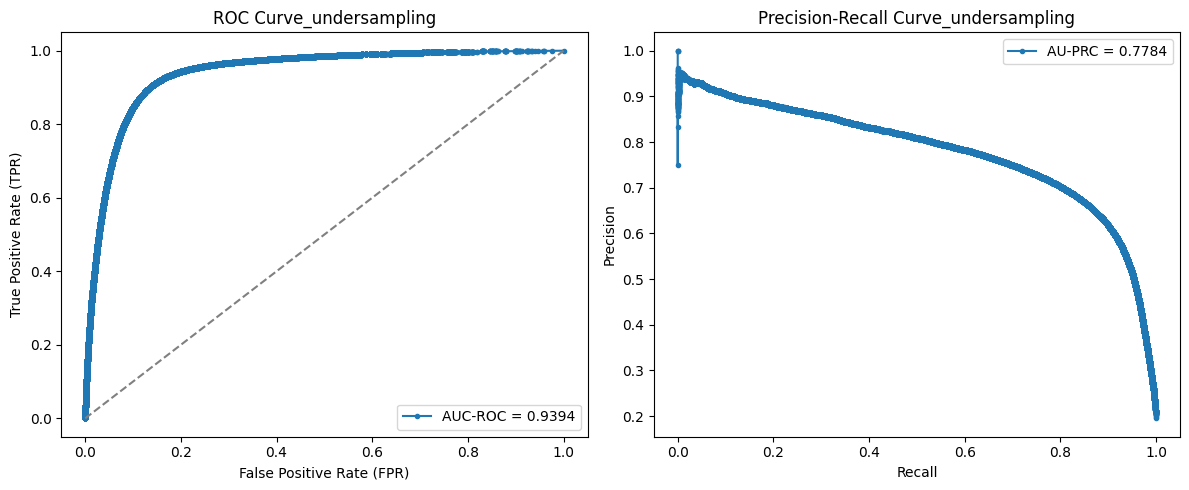

In [69]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

<Figure size 1000x800 with 0 Axes>

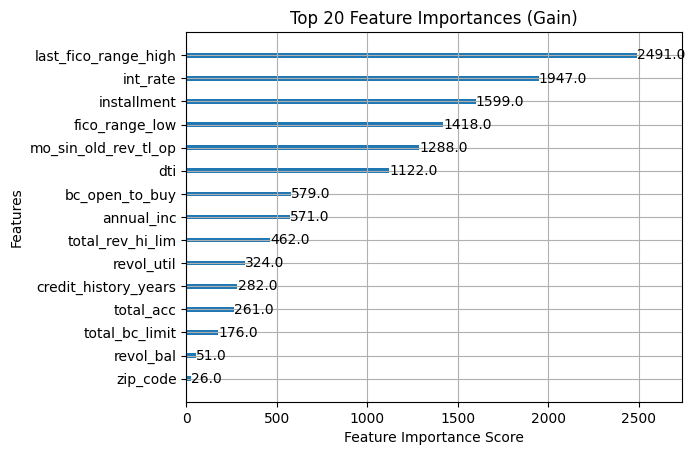

In [70]:
###xgboost feature gain 확인
import xgboost as xgb
# 8️⃣ Feature Importance 추출 및 시각화
plt.figure(figsize=(10, 8))
xgb.plot_importance(
    model,
    importance_type='weight',  # 중요도 계산 방법: 'weight', 'gain', 'cover' 중 선택 가능
    max_num_features=20,     # 상위 20개 feature만 표시
    xlabel='Feature Importance Score',
    title='Top 20 Feature Importances (Gain)',
    grid=True
)
plt.show()

## Random Undersampling

In [71]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/test_dataset.csv"
test_data = pd.read_csv(test_data_path)

In [72]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

X_test = test_data.drop(columns = "loan_status")
y_test = test_data[['loan_status']]

In [73]:
# 클래스별 샘플 개수 확인
print("Original class distribution:\n", data_y.value_counts())

# 언더샘플링 적용 (Random Undersampling)
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(data_x, data_y)

# 결과 확인 (각 데이터셋 크기)
print(f"Original data size: {data_x.shape[0]} samples")
print(f"Undersampled data size: {X_under.shape[0]} samples")

# 데이터프레임 변환 (필요하면)
data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

# 언더샘플링 및 오버샘플링 결과 확인
print(f"\nUndersampling imbalance check\n{data_under['loan_status'].value_counts()}")

Original class distribution:
 loan_status
0              1198226
1               290385
Name: count, dtype: int64
Original data size: 1488611 samples
Undersampled data size: 580770 samples

Undersampling imbalance check
loan_status
0    290385
1    290385
Name: count, dtype: int64


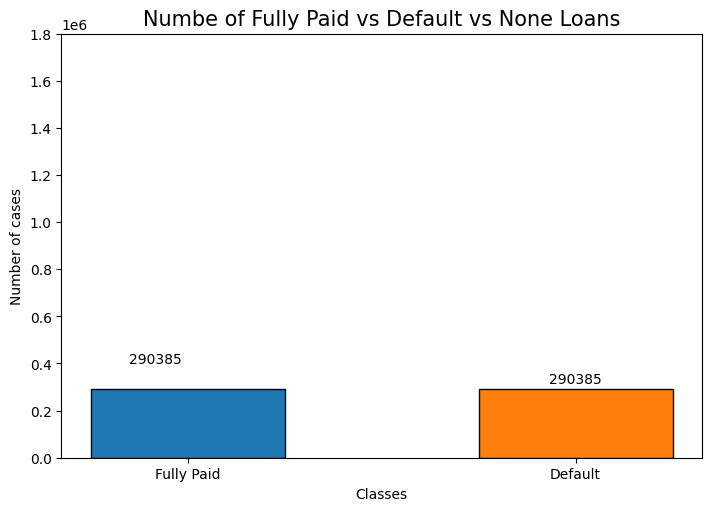

In [74]:
# Visualizing the encoded target

defalut_fully_paid = data_under['loan_status'].value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Numbe of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.7,400000,defalut_fully_paid[0])
# ax.text(5.6,1150000,none_)

fig.show()

In [75]:
data_x = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
data_y = data_under[['loan_status']]  # Target (타겟 변수)

In [76]:
# data under 6:2:2 train,val,test set

X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.20, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data_under):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data_under):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data_under):.1%})")

Train size: 464616 samples (80.0%)
Validation size: 116154 samples (20.0%)
Test size: 372153 samples (64.1%)


In [ ]:
"""scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Scaled data_x sample:\n", X_train_scaled.head())

# Z-score 저장 (나중에 다시 사용할 경우)
scaler_fitted = scaler"""

Scaled data_x sample:
          last_fico_range_high  int_rate  mo_sin_old_rev_tl_op       dti  \
1176866              2.169873 -0.667667              2.395112  0.146409   
1091007             -1.536747  0.184636             -0.804485 -0.402862   
975425               1.008097 -1.135442              0.466878  0.225090   
22038               -0.983520  0.295634             -0.889242  0.133670   
509255               0.344224  0.067693             -0.709132 -0.291209   

         annual_inc  zip_code  installment  fico_range_low  revol_util  \
1176866   -0.313358  0.742042     0.463426       -0.633030    0.893022   
1091007   -0.136846 -1.385005    -0.393787       -0.148924    0.019779   
975425    -0.693538 -0.052785    -0.747466       -0.633030   -0.552906   
22038     -0.517026  1.318051    -0.608622        0.012445   -0.045206   
509255    -0.530604  0.738825    -0.635644       -1.117135    0.482801   

         total_acc  total_bc_limit  revol_bal  total_rev_hi_lim  \
1176866  -1.11

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=200,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42
)

[0]	validation_0-logloss:0.68689	validation_1-logloss:0.68691
[1]	validation_0-logloss:0.68077	validation_1-logloss:0.68079
[2]	validation_0-logloss:0.67476	validation_1-logloss:0.67480
[3]	validation_0-logloss:0.66887	validation_1-logloss:0.66892
[4]	validation_0-logloss:0.66309	validation_1-logloss:0.66315
[5]	validation_0-logloss:0.65743	validation_1-logloss:0.65750
[6]	validation_0-logloss:0.65187	validation_1-logloss:0.65195
[7]	validation_0-logloss:0.64642	validation_1-logloss:0.64651
[8]	validation_0-logloss:0.64107	validation_1-logloss:0.64117
[9]	validation_0-logloss:0.63582	validation_1-logloss:0.63594
[10]	validation_0-logloss:0.63067	validation_1-logloss:0.63079
[11]	validation_0-logloss:0.62561	validation_1-logloss:0.62575
[12]	validation_0-logloss:0.62065	validation_1-logloss:0.62080
[13]	validation_0-logloss:0.61577	validation_1-logloss:0.61594
[14]	validation_0-logloss:0.61099	validation_1-logloss:0.61116
[15]	validation_0-logloss:0.60629	validation_1-logloss:0.60647
[1

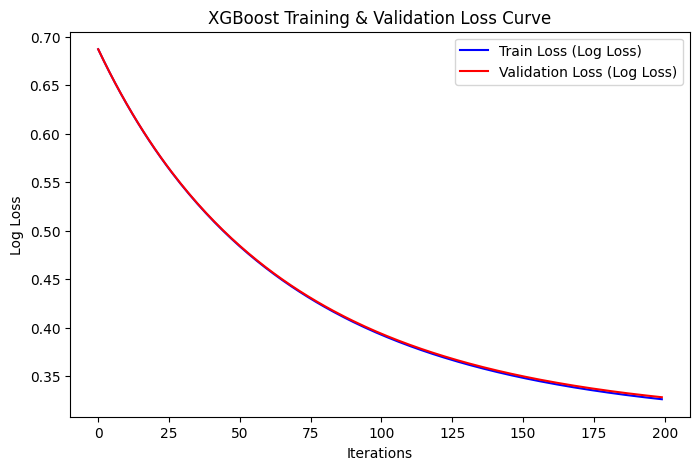

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91    299557
           1       0.61      0.91      0.73     72596

    accuracy                           0.87    372153
   macro avg       0.79      0.88      0.82    372153
weighted avg       0.90      0.87      0.88    372153



In [77]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

'''threshold = 0.3
y_pred_adjusted = (y_prob>threshold).astype(int)'''

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

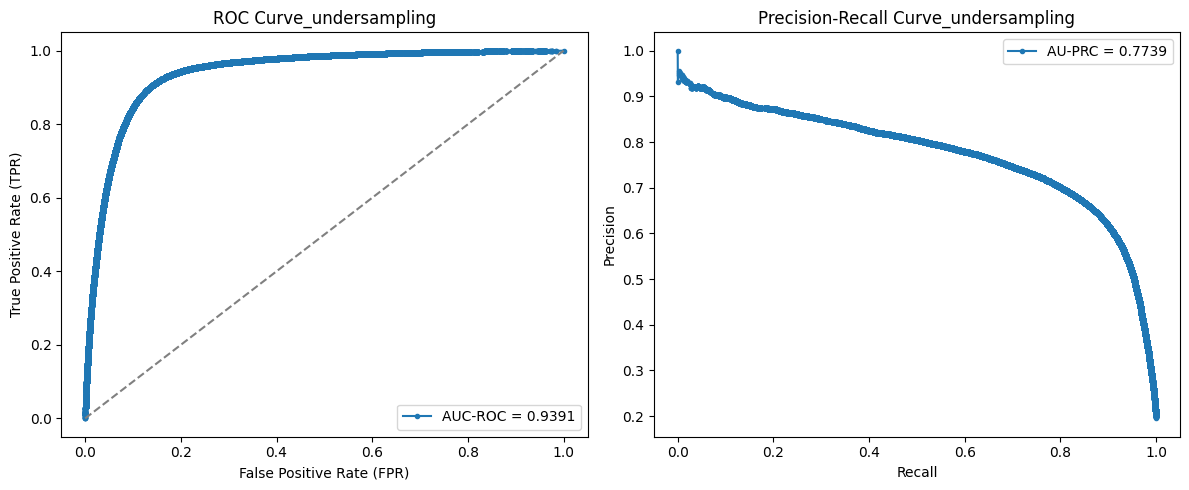

In [78]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

<Figure size 1000x800 with 0 Axes>

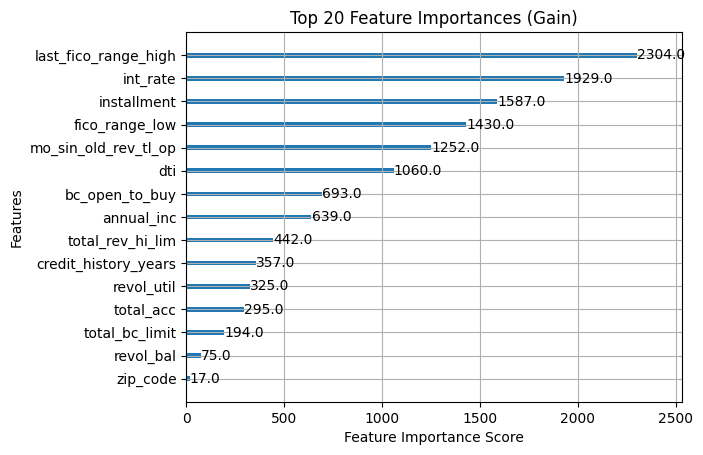

In [79]:
###xgboost feature gain 확인
import xgboost as xgb
# 8️⃣ Feature Importance 추출 및 시각화
plt.figure(figsize=(10, 8))
xgb.plot_importance(
    model,
    importance_type='weight',  # 중요도 계산 방법: 'weight', 'gain', 'cover' 중 선택 가능
    max_num_features=20,     # 상위 20개 feature만 표시
    xlabel='Feature Importance Score',
    title='Top 20 Feature Importances (Gain)',
    grid=True
)
plt.show()

## Oversampling SMOTE

In [80]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/train_dataset.csv"
data = pd.read_csv(data_path, low_memory=False)

In [81]:
data_x = data.drop(columns='loan_status')
data_y = data[['loan_status']]

In [ ]:
"""from imblearn.over_sampling import SMOTE
import pandas as pd

# SMOTE 객체 생성
smote = SMOTE(random_state=42)

# 오버샘플링 수행
X_train_smote, y_train_smote = smote.fit_resample(data_x, data_y)

# 결과 확인
print(f"✅ SMOTE 적용 완료")
print(f"📦 X_train_smote shape: {X_train_smote.shape}")
print(y_train_smote.value_counts())

## 증강 시간이 오래 걸리기 때문 데이터 저장을 한다.
augmentation_data = pd.concat([X_train_smote, y_train_smote], axis = 1)

address = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"

augmentation_data.to_csv(path_or_buf=address+"smote_data.csv", index=False)"""

✅ SMOTE 적용 완료
📦 X_train_smote shape: (2396452, 15)
loan_status
0              1198226
1              1198226
Name: count, dtype: int64


In [82]:
##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/test_dataset.csv"
test_data = pd.read_csv(test_data_path)

data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/smote_data.csv"
augmentation_data = pd.read_csv(data_path)

print(f"Augmentation_data the number of columns : {len(augmentation_data.columns)}")

Augmentation_data the number of columns : 16


In [83]:
X_train_smotenc = augmentation_data.drop(columns='loan_status')
y_train_smotenc = augmentation_data[['loan_status']]

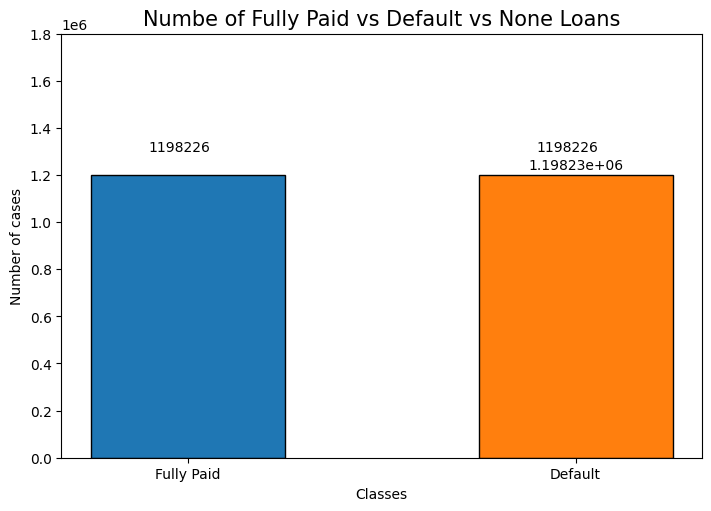

In [84]:
# Visualizing the encoded target

defalut_fully_paid = y_train_smotenc.value_counts()

fig, ax = plt.subplots(figsize=(7,5), layout='constrained')
rects = ax.bar(x=2, height=defalut_fully_paid[0], width=1, label="Fully Paid", edgecolor="black")
rects = ax.bar(x=4, height=defalut_fully_paid[1], width=1, label="Default", edgecolor="black")
ax.bar_label(rects, padding=2)


ax.set_ylabel('Number of cases',size=10)
ax.set_xlabel('Classes',size=10)
ax.set_title('Numbe of Fully Paid vs Default vs None Loans',size=15)

ax.set_xticks([2,4], ["Fully Paid","Default"])

ax.set_ylim(0, 1800000)

ax.text(1.8,1300000,defalut_fully_paid[0])
ax.text(3.8,1300000,defalut_fully_paid[1])

fig.show()

In [85]:
# data under 6:2:2 train,val,test set

X_train, X_val, y_train, y_val = train_test_split(X_train_smotenc, y_train_smotenc, test_size=0.2, random_state=42, stratify=y_train_smotenc)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(augmentation_data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(augmentation_data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(augmentation_data):.1%})")

Train size: 1917161 samples (80.0%)
Validation size: 479291 samples (20.0%)
Test size: 372153 samples (15.5%)


In [ ]:
"""scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("Scaled data_x sample:\n", X_train_scaled.head())

# Z-score 저장 (나중에 다시 사용할 경우)
scaler_fitted = scaler"""

Scaled data_x sample:
          last_fico_range_high  int_rate  mo_sin_old_rev_tl_op       dti  \
760331               0.749782 -0.656730             -0.378799 -0.303127   
933016              -0.949238 -1.146297             -0.908155 -0.186195   
2104334             -1.220665  0.909805              1.491646 -0.915851   
1684153             -1.199248  1.162361              0.848777 -0.271456   
1971934             -1.250426 -0.318685             -1.302100  0.229381   

         annual_inc  zip_code  installment  fico_range_low  revol_util  \
760331     0.144370 -1.459080    -0.236592        3.525851   -1.632355   
933016    -0.194818 -1.032812     0.957584       -0.152870    0.202985   
2104334   -0.040642 -0.316187    -0.400122       -1.112734    0.426130   
1684153   -0.279159 -0.055861    -0.369948        0.653499   -1.507349   
1971934   -0.387539 -0.757137    -1.045144        0.571364    0.991454   

         total_acc  total_bc_limit  revol_bal  total_rev_hi_lim  \
760331   -0.82

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=200,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42
)

[0]	validation_0-logloss:0.68631	validation_1-logloss:0.68630
[1]	validation_0-logloss:0.67961	validation_1-logloss:0.67959
[2]	validation_0-logloss:0.67302	validation_1-logloss:0.67301
[3]	validation_0-logloss:0.66659	validation_1-logloss:0.66657
[4]	validation_0-logloss:0.66027	validation_1-logloss:0.66024
[5]	validation_0-logloss:0.65406	validation_1-logloss:0.65402
[6]	validation_0-logloss:0.64796	validation_1-logloss:0.64791
[7]	validation_0-logloss:0.64199	validation_1-logloss:0.64193
[8]	validation_0-logloss:0.63613	validation_1-logloss:0.63606
[9]	validation_0-logloss:0.63038	validation_1-logloss:0.63030
[10]	validation_0-logloss:0.62473	validation_1-logloss:0.62465
[11]	validation_0-logloss:0.61916	validation_1-logloss:0.61908
[12]	validation_0-logloss:0.61371	validation_1-logloss:0.61362
[13]	validation_0-logloss:0.60836	validation_1-logloss:0.60826
[14]	validation_0-logloss:0.60311	validation_1-logloss:0.60300
[15]	validation_0-logloss:0.59795	validation_1-logloss:0.59785
[1

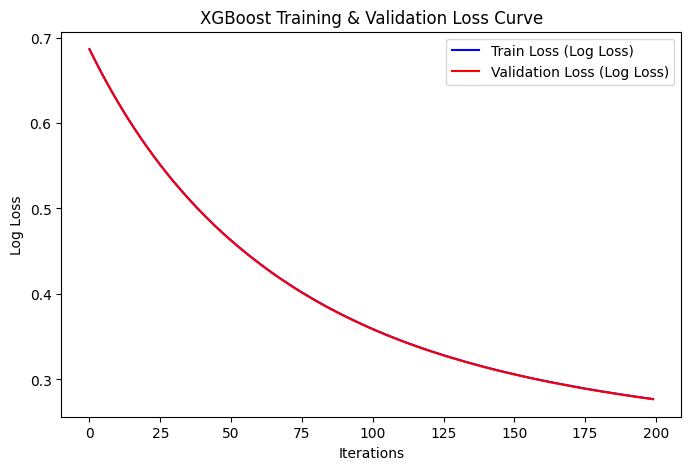

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92    299557
           1       0.64      0.87      0.74     72596

    accuracy                           0.88    372153
   macro avg       0.80      0.88      0.83    372153
weighted avg       0.90      0.88      0.89    372153



In [87]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

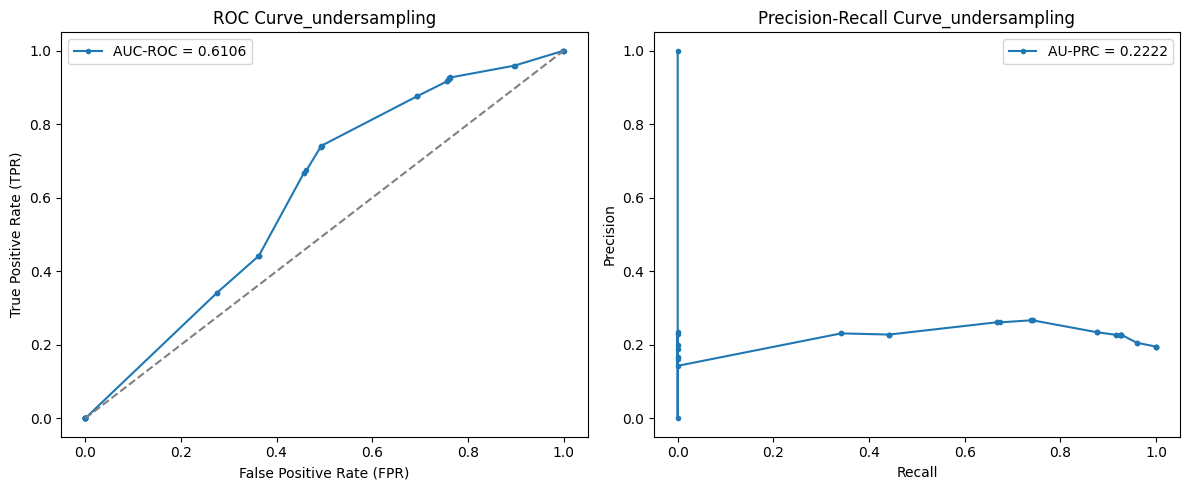

In [46]:
# 8️⃣ ROC & Precision-Recall Curve 시각화 함수
def plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc):
    plt.figure(figsize=(12, 5))

    # 🔹 ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=f"AUC-ROC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 모델 기준선
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve_undersampling')
    plt.legend()

    # 🔹 Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', label=f"AU-PRC = {auc_prc:.4f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve_undersampling')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 9️⃣ 결과 시각화 실행
plot_evaluation_curves(fpr, tpr, auc_roc, recall, precision, auc_prc)

<Figure size 1000x800 with 0 Axes>

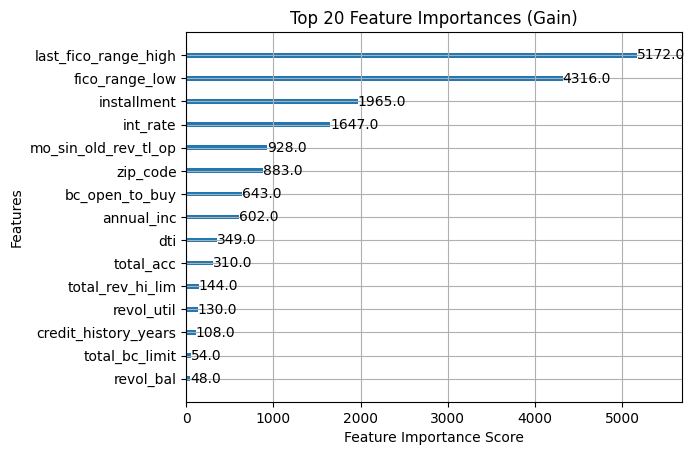

In [47]:
###xgboost feature gain 확인
import xgboost as xgb
# 8️⃣ Feature Importance 추출 및 시각화
plt.figure(figsize=(10, 8))
xgb.plot_importance(
    model,
    importance_type='weight',  # 중요도 계산 방법: 'weight', 'gain', 'cover' 중 선택 가능
    max_num_features=20,     # 상위 20개 feature만 표시
    xlabel='Feature Importance Score',
    title='Top 20 Feature Importances (Gain)',
    grid=True
)
plt.show()